Ce notebook montre comment mesurer le risque de perte d’un portefeuille avec :
- **VaR historique**
- **VaR paramétrique (normale)**
- **Expected Shortfall (ES)**
- **Méthode Monte Carlo**


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st


In [ ]:

tickers = ["AAPL","MSFT","SPY"]
data = yf.download(tickers, start="2020-01-01", end="2023-12-31", auto_adjust=False)["Adj Close"]
data.head()


[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,MSFT,SPY
Date,,,
2020-01-02,72.538506,153.042313,299.406403
2020-01-03,71.833298,151.136612,297.139252
2020-01-06,72.405678,151.527298,298.272888
2020-01-07,72.065140,150.145706,297.434204
2020-01-08,73.224426,152.537277,299.019409


📊 3. Rendements du portefeuille

In [ ]:
weights = [1/3,1/3,1/3]
returns = data.pct_change().dropna()
portfolio_returns = returns.dot(weights)
portfolio_returns.head()

,0
Date,
2020-01-03,-0.009915
2020-01-06,0.004789
2020-01-07,-0.005544
2020-01-08,0.012448
2020-01-09,0.013505


📉 4. Fonctions VaR & ES

In [ ]:

def var_historical(returns, alpha=0.05):
    return np.percentile(returns, 100*alpha)

def es_historical(returns, alpha=0.05):
    var = var_historical(returns, alpha)
    return returns[returns <= var].mean()

def var_parametric(returns, alpha=0.05):
    mu, sigma = returns.mean(), returns.std()
    return mu + sigma * st.norm.ppf(alpha)

def es_parametric(returns, alpha=0.05):
    mu, sigma = returns.mean(), returns.std()
    return mu - sigma * st.norm.pdf(st.norm.ppf(alpha)) / alpha

def var_es_montecarlo(returns, alpha=0.05, n_sim=100000):
    mu, sigma = returns.mean(), returns.std()
    sims = np.random.normal(mu, sigma, n_sim)
    var = np.percentile(sims, 100*alpha)
    es = sims[sims <= var].mean()
    return var, es


5. Calcul et comparaison

In [ ]:
alpha = 0.05
results = {
    "Historique": (var_historical(portfolio_returns, alpha), es_historical(portfolio_returns, alpha)),
    "Paramétrique": (var_parametric(portfolio_returns, alpha), es_parametric(portfolio_returns, alpha)),
    "Monte Carlo": var_es_montecarlo(portfolio_returns, alpha)
}

for method,(var,es) in results.items():
    print(f"{method}: VaR={var:.4%}, ES={es:.4%}")



Historique: VaR=-2.5799%, ES=-3.9597%
Paramétrique: VaR=-2.7669%, ES=-3.4937%
Monte Carlo: VaR=-2.7671%, ES=-3.4996%


6. Visualisations

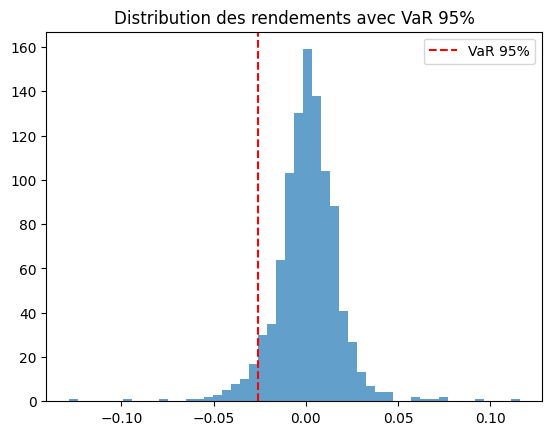

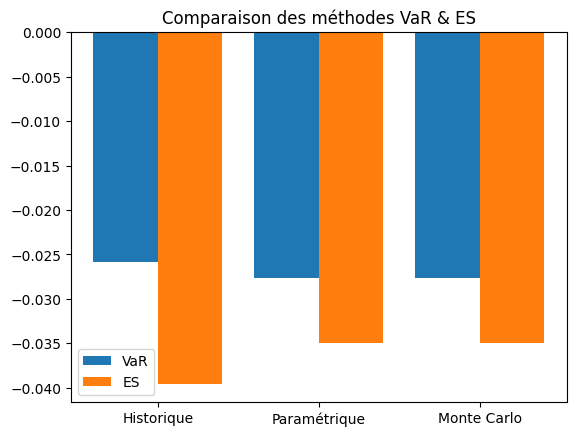

In [ ]:
plt.hist(portfolio_returns, bins=50, alpha=0.7)
plt.axvline(results["Historique"][0], color='red', linestyle='--', label=f"VaR 95%")
plt.legend()
plt.title("Distribution des rendements avec VaR 95%")
plt.show()

# Comparaison
methods = list(results.keys())
var_values = [v[0] for v in results.values()]
es_values = [v[1] for v in results.values()]

x = np.arange(len(methods))
plt.bar(x-0.2, var_values, 0.4, label="VaR")
plt.bar(x+0.2, es_values, 0.4, label="ES")
plt.xticks(x, methods)
plt.legend()
plt.title("Comparaison des méthodes VaR & ES")
plt.show()